# Cell/particle Counting and scoring stained objects

This notebook demonstrates how to process plates associated to the paper ['Integration of biological data by kernels on graph nodes allows prediction of new genes involved in mitotic chromosome condensation.'](http://dx.doi.org/10.1091/mbc.E13-04-0221) using [CellProfiler](http://cellprofiler.org/).
We use the example pipeline [Cell/particle counting, and scoring the percentage of stained objects](http://cellprofiler.org/examples/#PercentPositive). This pipeline is for two-channel images.

In [ ]:
# When running the notebook on M1,
# you might have to run this cell after removing the comment
#import os
#os.environ["JAVA_HOME"]="/full/path/to/conda_env"

### Import Packages

In [ ]:
# %tb

# Import Cell Profiler Dependencies
import cellprofiler
import cellprofiler_core.preferences as cpprefs
import cellprofiler.modules as cpm
import cellprofiler_core.pipeline as cpp
cpprefs.set_headless()

# Inject Image module used to inject OMERO image planes into Cell Profiler Pipeline
from cellprofiler_core.modules.injectimage import InjectImage
from cellprofiler_core.modules.inject_objects import InjectObjects
# Import OMERO Python BlitzGateway
import omero
from omero.gateway import BlitzGateway

# Import Numpy
import numpy as np

# Import Python System Packages
import os
import tempfile
import pandas
import warnings

#stardist related
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from stardist.plot import render_label
import matplotlib.pyplot as plt

#load stardist model
model = StarDist2D.from_pretrained('2D_versatile_fluo')



Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


### Set Cell Output Directory

In [20]:
new_output_directory = os.path.normcase(tempfile.mkdtemp())
cpprefs.set_default_output_directory(new_output_directory)

### Connect to OMERO

In [21]:
conn = BlitzGateway(host='localhost', username='root', passwd='omero', secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


### Fetch from IDR the Plate that contains the Images to be analysed

In [22]:
plate_id = 51

plate = conn.getObject("Plate", plate_id)
print('Plate Name: ', plate.getName())

Plate Name:  sam_ome_tif


In [ ]:
# Load pipeline and inspect modules
pipeline = cpp.Pipeline()
pipeline.load("./pipelines/measure_nuclei_int.cppipe")

# Remove first 4 modules: Images, Metadata, NamesAndTypes, Groups...
# (replaced by InjectImage module below)
for i in range(4):
    print('Remove module: ', pipeline.modules()[0].module_name)
    pipeline.remove_module(1)

print('Pipeline modules:')
for module in pipeline.modules():
    print(module.module_num, module.module_name)


Remove module:  Images
Remove module:  Metadata
Remove module:  NamesAndTypes
Remove module:  Groups
Pipeline modules:
1 MeasureObjectIntensity
2 ExportToSpreadsheet


### Run Cell Profiler Pipeline on the plate

Well: 1/3 row: 0 column: 0


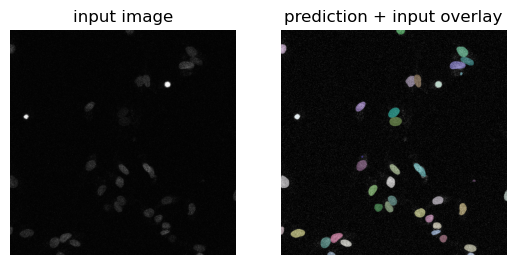

size label: (1024, 1024)
Well: 2/3 row: 0 column: 1


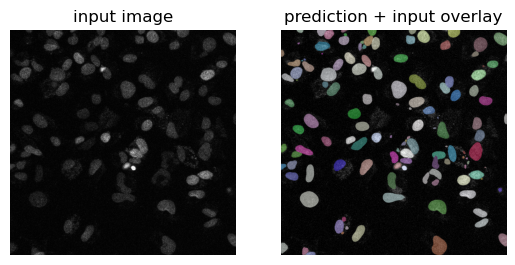

size label: (1024, 1024)
Well: 3/3 row: 0 column: 2


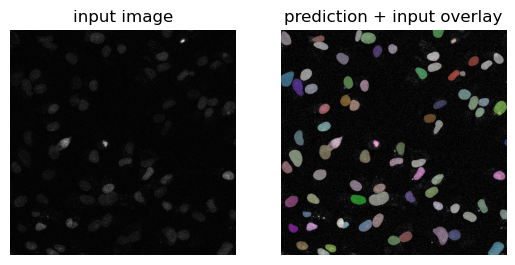

size label: (1024, 1024)


In [30]:
warnings.filterwarnings('ignore')

Nuclei = pandas.DataFrame()
files = list()

# create list from generator
wells = list(plate.listChildren())
# use the first 5 wells only
wells = wells[0:3]
well_count = len(wells)

for count, well in enumerate(wells):
    print('Well: %s/%s' % (count + 1, well_count), 'row:', well.row, 'column:', well.column)
    # Load a single Image per Well
    image = well.getImage(0)
    pixels = image.getPrimaryPixels()
    size_c = image.getSizeC()
    nuc_img = pixels.getPlane(0, 0, 0)
    #apply stardist on nuclei channel
    labels, _ = model.predict_instances(normalize(nuc_img))
    plt.subplot(1,2,1)
    plt.imshow(nuc_img, cmap="gray")
    plt.axis("off")
    plt.title("input image")

    plt.subplot(1,2,2)
    plt.imshow(render_label(labels, img=nuc_img))
    plt.axis("off")
    plt.title("prediction + input overlay")
    plt.show()

    pipeline_copy = pipeline.copy()

    print('size label:', labels.shape)
    # For each Image in OMERO, we copy pipeline and inject image modules
    # Inject image for each Channel (pipeline only handles 2 channels)
    for c in range(0, size_c):

        plane = pixels.getPlane(0, c, 0)
        image_name = image.getName()

        # Name of the channel expected in the pipeline
        if c == 0:
            image_name = 'DNA'
        if c == 1:
            image_name = 'mito'
        if c == 2:
            image_name = 'PI'
        if c == 3:
            image_name = 'trans'
        inject_image_module = InjectImage(image_name, plane)
        inject_image_module.set_module_num(1)
        pipeline_copy.add_module(inject_image_module)
    
    inject_object_module = InjectObjects('Nuclei',labels)
    inject_object_module.set_module_num(1)
    pipeline_copy.add_module(inject_object_module)
    m = pipeline_copy.run()

    # Results obtained as CSV from Cell Profiler
    path = new_output_directory + '/Nuclei.csv'
    f = pandas.read_csv(path, index_col=None, header=0)
    f['Image'] = image.getId()
    f['Well'] = well.getId()
    f['Cell_Count'] = len(f.index)
    files.append(f)

Nuclei = pandas.concat(files, ignore_index=True)

### Calculate statistics

In [10]:
Nuclei.describe()

,ImageNumber,ObjectNumber,Children_PH3PosNuclei_Count,Children_PH3_Count,Classify_PH3Neg,Classify_PH3Pos,Intensity_IntegratedIntensityEdge_OrigBlue,Intensity_IntegratedIntensityEdge_OrigGreen,Intensity_IntegratedIntensity_OrigBlue,Intensity_IntegratedIntensity_OrigGreen,...,Location_MaxIntensity_X_OrigBlue,Location_MaxIntensity_X_OrigGreen,Location_MaxIntensity_Y_OrigBlue,Location_MaxIntensity_Y_OrigGreen,Location_MaxIntensity_Z_OrigBlue,Location_MaxIntensity_Z_OrigGreen,Number_Object_Number,Image,Well,Cell_Count
count,34.0,34.000000,34.0,34.0,34.0,34.0,34.000000,34.000000,34.000000,34.000000,...,34.000000,34.000000,34.000000,34.000000,34.0,34.0,34.000000,34.0,34.0,34.0
mean,1.0,17.500000,0.0,0.0,1.0,0.0,0.968295,1.951004,28.334324,31.246165,...,551.441176,550.441176,568.117647,574.441176,0.0,0.0,17.500000,179694.0,67063.0,34.0
std,0.0,9.958246,0.0,0.0,0.0,0.0,0.199536,0.655392,11.541393,13.983118,...,392.536058,391.959815,280.957752,284.210570,0.0,0.0,9.958246,0.0,0.0,0.0
min,1.0,1.000000,0.0,0.0,1.0,0.0,0.195392,0.188174,0.925505,0.549798,...,48.000000,51.000000,44.000000,33.000000,0.0,0.0,1.000000,179694.0,67063.0,34.0
25%,1.0,9.250000,0.0,0.0,1.0,0.0,0.880880,1.533471,23.716915,23.304788,...,207.000000,206.500000,302.250000,301.500000,0.0,0.0,9.250000,179694.0,67063.0,34.0
50%,1.0,17.500000,0.0,0.0,1.0,0.0,0.998833,2.100252,26.726955,34.784375,...,505.500000,517.000000,646.000000,641.500000,0.0,0.0,17.500000,179694.0,67063.0,34.0
75%,1.0,25.750000,0.0,0.0,1.0,0.0,1.084237,2.378832,31.821382,37.411639,...,865.000000,878.000000,803.500000,813.000000,0.0,0.0,25.750000,179694.0,67063.0,34.0
max,1.0,34.000000,0.0,0.0,1.0,0.0,1.276707,3.285237,70.744503,66.551629,...,1296.000000,1297.000000,946.000000,967.000000,0.0,0.0,34.000000,179694.0,67063.0,34.0


### Close the connection to the server

In [ ]:
conn.close()

### License (BSD 2-Clause)
Copyright (C) 2020-2023 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.